In [1]:
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ajouter tree-specie
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok


#preprocessing bdiff:
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

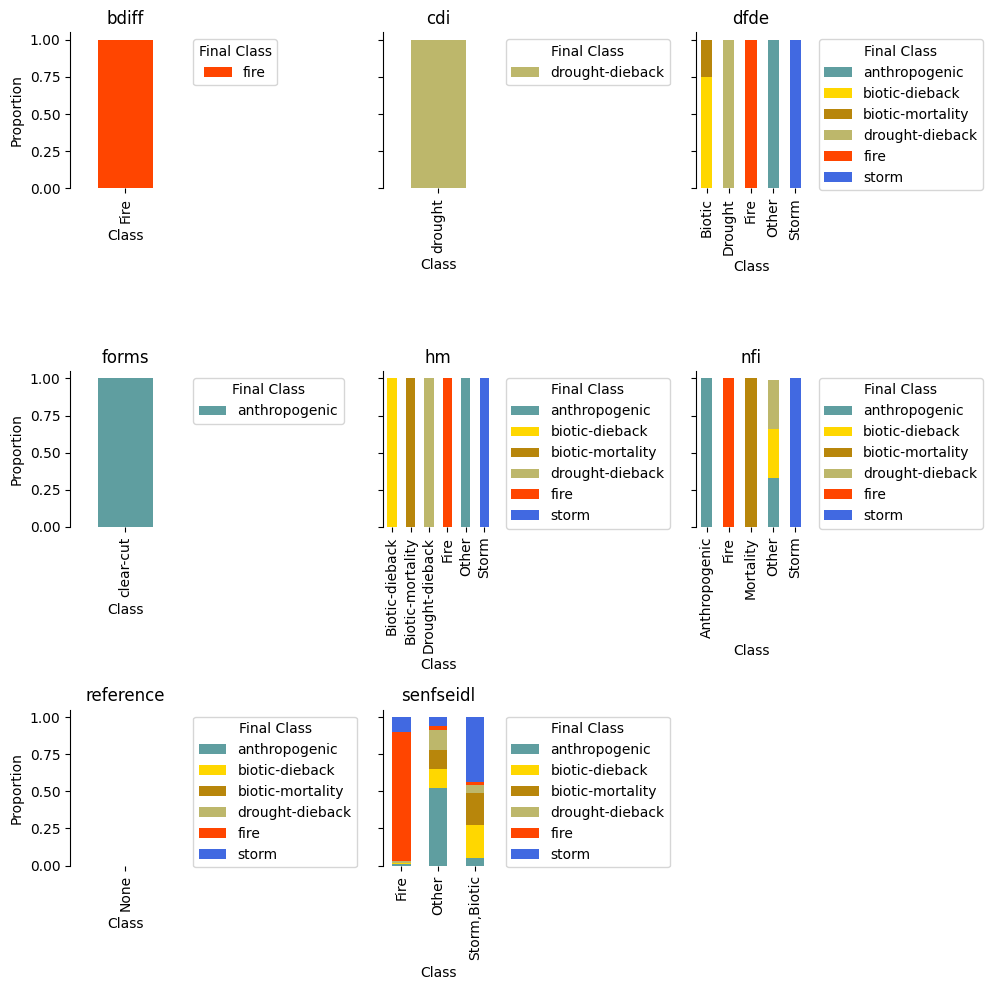

In [2]:
from constants import DCLASS_SCORE

DCLASS_SCORE = {
    'senfseidl': {
        'Storm,Biotic': {'biotic-mortality':0.22, 'storm':0.44, 'biotic-dieback':0.22, 'drought-dieback':0.05, 'fire':0.02, 'anthropogenic':0.05},
        'Fire' : {'fire':0.87, 'storm':0.1, 'biotic-dieback':0.01, 'drought-dieback':0.01, 'anthropogenic':0.01},
        'Other' : {'storm':0.06, 'fire':0.03, 'biotic-mortality':0.13, 'biotic-dieback':0.13, 'drought-dieback':0.13, 'anthropogenic':0.52}
    },
    'dfde': {
        'Biotic':{'biotic-mortality':0.25, 'biotic-dieback':0.75},
        'Storm':{'storm':1.},
        'Fire':{'fire':1.},
        'Drought':{'drought-dieback':1.},
        'Other':{'anthropogenic':1.}
    },
    'nfi': {
        'Mortality':{'biotic-mortality':1.0},
        'Storm':{'storm':1.},
        'Fire':{'fire':1.},
        'Other':{'anthropogenic':0.33, 'drought-dieback':0.33, 'biotic-dieback':0.33},
        'Anthropogenic':{'anthropogenic':1.} 
    },
    'hm': {
        'Biotic-mortality':{'biotic-mortality':1.},
        'Biotic-dieback': {'biotic-dieback':1.},
        'Storm':{'storm':1.},
        'Fire':{'fire':1.},
        'Drought-dieback':{'drought-dieback':1.},
        'Other':{'anthropogenic':1.},
    },
    'cdi': {
    'drought': {'drought-dieback':1.},
    },
    'forms': {
    'clear-cut': {'anthropogenic':1.},
    },
    'bdiff': {
        'Fire':{'fire':1.}
    },
    'reference': {
        'None':{'biotic-mortality':0., 'biotic-dieback':0., 'storm':0., 'fire':0., 'drought-dieback':0., 'anthropogenic':0.},
    }}


import matplotlib.pyplot as plt
import pandas as pd

# Custom color mapping
custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

final_classes = ['fire', 'storm', 'biotic-dieback', 'biotic-mortality', 'drought-dieback', 'anthropogenic']

# Convert nested dictionary into a DataFrame for seaborn plotting
data = []
for dataset, classes in DCLASS_SCORE.items():
    for class_name, scores in classes.items():
        for final_class, score in scores.items():
            data.append({'Dataset': dataset, 'Class': class_name, 'Final Class': final_class, 'Score': score})

df = pd.DataFrame(data)

# Set the color palette to custom colors
palette = sns.color_palette([custom_color_mapping[fc] for fc in sorted(final_classes) if fc in custom_color_mapping])

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes

# Plot each dataset in its subplot
for ax, (dataset, dataset_df) in zip(axes, df.groupby('Dataset')):
    
    a = dataset_df.sort_values('Final Class').pivot_table(index=['Dataset', 'Class'], columns='Final Class', values='Score', fill_value=0)
    if dataset_df['Final Class'].nunique() == 1:
        c = custom_color_mapping[dataset_df['Final Class'].iloc[0]]
    else :
        c = palette

    # a = a.reindex(columns=final_classes, fill_value=0)
    a.reset_index().plot.bar(x='Class', stacked=True, ax=ax, color=c)
    # sns.barplot(x='Class', y='Score', hue='Final Class', data=dataset_df.sort_values('Final Class'), ax=ax, palette=palette, dodge=False, estimator=sum)
    ax.set_title(f'{dataset}')
    ax.set_ylabel('Proportion')
    ax.legend(title='Final Class', bbox_to_anchor=(1.05, 1), loc='upper left')



for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Hide remaining empty subplots
for i in range(len(DCLASS_SCORE), len(axes)):
    axes[i].set_visible(False)
    

plt.tight_layout()
plt.show()



In [2]:
#autoreload 
from attribution import Attribution

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 1000}),
        'temporal': ('weighting_function', {'x0': 30, 'k': 365})
    },
    'hm': {
        'spatial': ('weighting_function', {'x0': 100, 'k': 1000}),
        'temporal': ('weighting_function', {'x0': 30, 'k': 180})
    },
    'nfi': {
        'spatial': ('weighting_function', {'x0': 600, 'k': 1500}),
        'temporal': ('weighting_function', {'x0': 180, 'k': 2.5 * 365})
    },
    'senfseidl': {
        'spatial': ('weighting_function', {'x0': 30, 'k': 100}),
        'temporal': ('weighting_function', {'x0': 180, 'k': 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 1000}),
        'temporal': ('weighting_function', {'x0': 10, 'k': 90})
    },
    'cdi': {
        'spatial': ('weighting_function', {'x0': 5000, 'k': 500}),
        'temporal': ('weighting_function', {'x0': 10, 'k': 90})
    },
    'forms': {
        'spatial': ('weighting_function', {'x0': 30, 'k': 100}),
        'temporal': ('weighting_function', {'x0': 90, 'k': 180})
    },
    'reference': {
        'spatial': ('weighting_function', {'x0': 30, 'k': 100}),
        'temporal': ('weighting_function', {'x0': 30, 'k': 180})
    }
}


ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('exponential_decay', {'x0': 0, 'k': 0.0025})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('exponential_decay', {'x0': 0, 'k': 0.0025})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 100}),
        'temporal': ('exponential_decay', {'x0': 0, 'k': 0.005})
    },
    'anthropogenic': {
        'spatial': ('step', {'start': 0, 'end': 250}),
        'temporal': ('step', {'start': 0, 'end': 365})
    }
}

# dspatial_f = {'dfde': (3000, 0), 'hm': (1000, 0), 'nfi': (3000, 600), 'senfseidl': (500, 0), 'bdiff': (500, 0), 'cdi':(3000, 0), 'forms':(500, 0)}
# dtemporal_f = {'dfde': (365, 0), 'hm': (180, 0), 'nfi': (2.5 * 365, 0), 'senfseidl': (180, 0), 'bdiff': (180, 0), 'cdi':(180, 0), 'forms':(180, 0)} 

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': 1., 'bdiff': 1.0, 'cdi':.5, 'forms':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100}

from constants import DCLASS_SCORE

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 174.72 km2, median : 25.00 km2


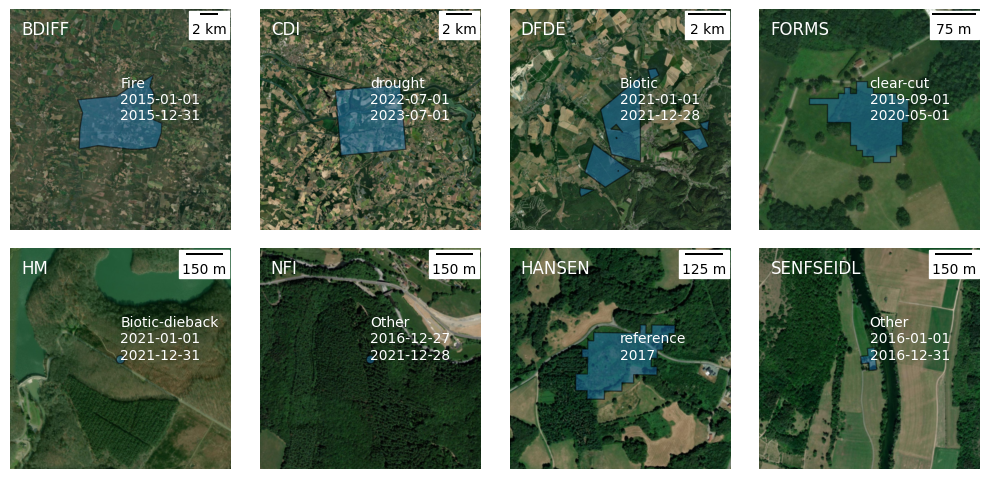

In [3]:
fig = attribution.plot_dataset_examples()

In [6]:
fig.savefig('../figures/dataset_examples.png', dpi=300, bbox_inches='tight')

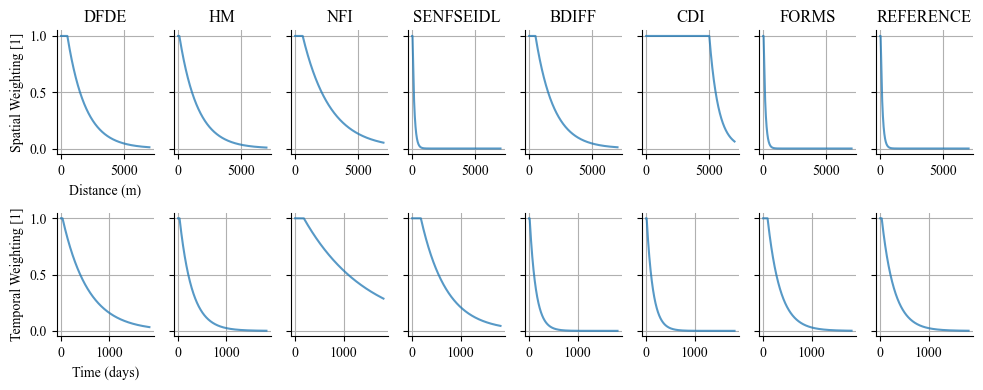

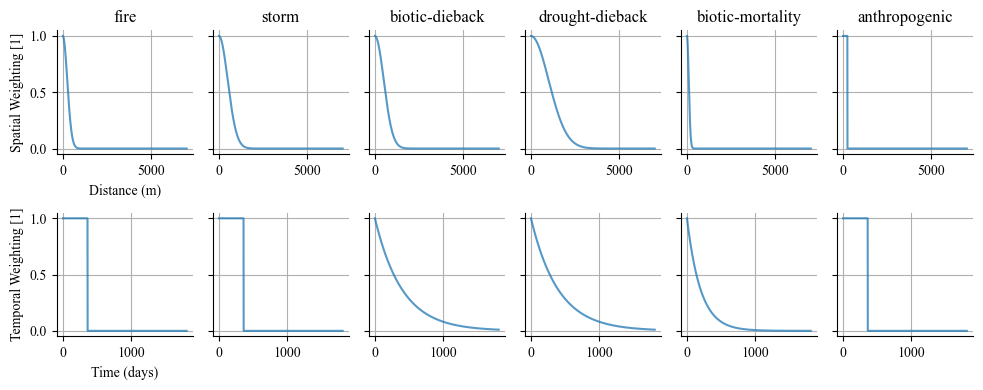

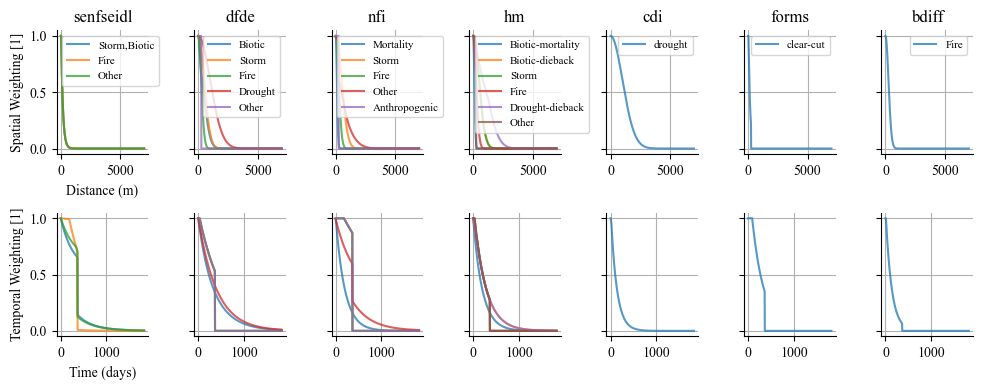

In [4]:
fig1, fig2, fig3 = attribution.plot_weighting_functions()

In [5]:
fig1.savefig('../figures/spatial_weighting_functions_datasets.png', dpi=300, bbox_inches='tight')

In [6]:
fig2.savefig('../figures/temporal_weighting_functions_disturbances.png', dpi=300, bbox_inches='tight')

In [7]:
fig3.savefig('../figures/temporal_weighting_functions_combine.png', dpi=300, bbox_inches='tight')

In [4]:
pd.options.mode.chained_assignment = None
import time 

from utils import compute_tree_coherence, compute_class_similarity
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': DCLASS_SCORE}, 1.0)}

year = 2018 
# attribution.get_clusters(year, dcustom_similiraity_function=dcustom_similarity_function, dir_=f'../data/results/cluster_{year}')
attribution_year = attribution.get_temporal_spatial_join(year, dir_=f'../data/results/cluster_{year}')
 

In [8]:
year = 2018 
attribution_year = gpd.read_parquet(f'../data/results/cluster_{year}/disturbances_{year}_g{attribution.granularity}_v{attribution.version}.parquet')

In [9]:
attribution_year

,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,essence_bdforet,ref_dfde,notes,severity,forest_area_m2,name,cause,intensity,sd
0,1667070,1667070,"POLYGON ((998440.206 6845680.531, 998444.483 6...",2018.0,Mixed,mixed,<NA>,2018-01-01,2018-12-31,reference,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,NaN
1,82,1667070,"MULTIPOLYGON (((1003074.334 6847476.625, 10029...",NaN,broadleaf,broadleaves,Biotic,2020-01-01,2020-12-28,dfde,beech,65.0,<NA>,<NA>,NaN,<NA>,Armillaria mellea,NaN,NaN
2,86,1667070,"MULTIPOLYGON (((1003074.334 6847476.625, 10029...",NaN,broadleaf,european beech,Biotic,2020-01-01,2020-12-28,dfde,beech,67.0,<NA>,<NA>,NaN,<NA>,Beech decline,NaN,NaN
3,87,1667070,"MULTIPOLYGON (((1003074.334 6847476.625, 10029...",NaN,broadleaf,broadleaves,Biotic,2020-01-01,2020-12-28,dfde,beech,68.0,<NA>,<NA>,NaN,<NA>,Chalara fraxinea;Hymenoscyphus fraxineus,NaN,NaN
4,98,1667070,"MULTIPOLYGON (((1003074.334 6847476.625, 10029...",NaN,broadleaf,broadleaves,Biotic,2020-01-01,2020-12-28,dfde,beech,74.0,<NA>,<NA>,NaN,<NA>,Viscum album,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385410,41200,4705456,"POLYGON ((348230.159 6277518.901, 348240.159 6...",NaN,Broadleaf,broadleaf,clear-cut,2018-09-01,2019-05-01,forms,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,0.000000
385411,4737638,4737638,"POLYGON ((375909.152 6269692.305, 375907.743 6...",2018.0,<NA>,<NA>,<NA>,2018-01-01,2018-12-31,reference,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,NaN
385412,41306,4737638,"POLYGON ((375970.159 6269728.901, 375990.159 6...",NaN,Mixed,"deciduous oaks,poplar",clear-cut,2018-09-01,2019-05-01,forms,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,52.719115
385413,4911375,4911375,"POLYGON ((360622.624 6249392.032, 360621.154 6...",2018.0,<NA>,<NA>,<NA>,2018-01-01,2018-12-31,reference,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,NaN


In [5]:
attribution_year['dataset'].value_counts()

dataset
senfseidl    194035
reference     94341
bdiff         61785
forms         21002
hm            12487
cdi            1707
dfde             58
Name: count, dtype: Int64

In [10]:
groups = attribution_year.groupby('index_reference')
from itertools import islice
list_groups = []
for name, group in islice(groups, 1000):
    if group.dataset.nunique() > 3:
        list_groups.append(group)

In [129]:
index = 0 #0 #13 filter

In [153]:
data = list_groups[index]
index += 1
data


,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,essence_bdforet,ref_dfde,notes,severity,forest_area_m2,name,cause,intensity,sd,labels
404,1008123,1008123,"POLYGON ((635132.508 7003747.390, 635132.188 7...",2018.0,Broadleaf,broadleaf,<NA>,2018-01-01,2018-12-31,reference,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,NaN,1
405,308,1008123,"POLYGON ((635100.159 7003758.901, 635130.159 7...",NaN,Broadleaf,broadleaf,clear-cut,2017-09-01,2018-05-01,forms,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1
406,31334,1008123,POINT (635994.900 7003747.134),2016.0,conifer,Firs,Biotic-dieback,2016-01-01,2016-12-31,hm,<NA>,NaN,nan,3,NaN,<NA>,Chermès du tronc du sapin,NaN,778.454462,0
407,31886,1008123,POINT (635476.775 7004387.772),2016.0,conifer,Spruces,Biotic-dieback,2016-01-01,2016-12-31,hm,<NA>,NaN,nan,3,NaN,<NA>,Puceron vert de l'épicéa,NaN,727.055277,0
408,31887,1008123,POINT (635067.911 7004125.193),2016.0,broadleaf,Poplars,Biotic-mortality,2016-01-01,2016-12-31,hm,<NA>,NaN,"Robusta de 1984 très dépérissants, présentant ...",4,NaN,<NA>,Chancre bactérien des peupliers,NaN,378.490167,2
409,44303,1008123,"POLYGON ((635102.088 7003655.263, 635132.008 7...",2018.0,Broadleaf,broadleaf,Other,2018-01-01,2018-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1
410,44304,1008123,"POLYGON ((635164.782 7003631.173, 635159.076 7...",2018.0,Broadleaf,broadleaf,Other,2018-01-01,2018-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1
411,44305,1008123,"POLYGON ((635129.155 7003688.021, 635099.235 7...",2018.0,Broadleaf,broadleaf,Other,2018-01-01,2018-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1
412,46497,1008123,POINT (635139.840 7004592.076),2019.0,conifer,Spruces,Biotic-mortality,2019-01-01,2019-12-31,hm,<NA>,NaN,nan,4,NaN,<NA>,Typographe,NaN,844.715384,2
413,1627845,1008123,"POLYGON ((635188.996 7003693.800, 635218.916 7...",2017.0,Broadleaf,broadleaf,Other,2017-01-01,2017-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1


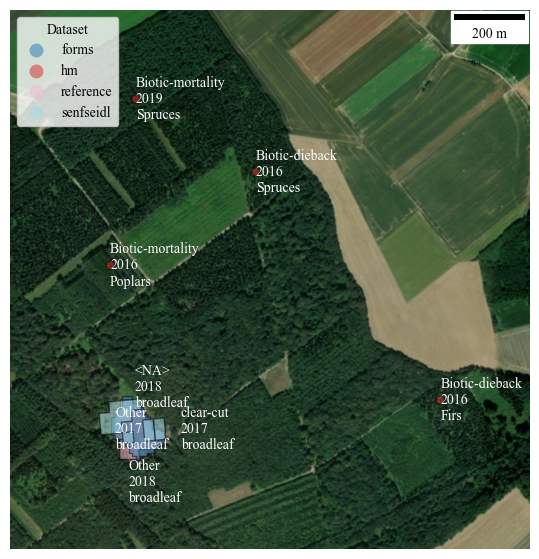

In [154]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
fig, ax = plt.subplots(figsize=(7, 7))

xmin, ymin, xmax, ymax = data.buffer(250).total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

data.plot(ax=ax, column='dataset', cmap='tab20', edgecolor='black', alpha=0.5, legend=True, legend_kwds={'loc': 'upper left', 'title': 'Dataset'})
ctx.add_basemap(ax, crs=data.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution=False)
ax.add_artist(ScaleBar(1))
ax.axis('off')



delta = 125
directions = [
    (0, delta),             # North
    (delta/2, delta/2),     # Northeast
    (delta, 0),             # East
    (delta/2, -delta/2),    # Southeast
    (0, -delta),            # South
    (-delta/2, -delta/2),   # Southwest
    (-delta, 0),            # West
    (-delta/2, delta/2)     # Northwest
]

j = 0
txts = []
for i, row in data.iterrows():
    if row.geometry.type == 'Point':
        x, y = row.geometry.centroid.x, row.geometry.centroid.y

        # Adjust position if necessary
        
        ax.annotate(f"{row['class']}\n{row['start_date'].year}\n{row['essence']}", xy=(x, y), horizontalalignment='left', verticalalignment='center', color='white', fontsize=10)

    else:
        #annotate in the lower left corner and avoid overlapping using i 
        txt = f"{row['class']}\n{row['start_date'].year}\n{row['essence']}"
        if txt not in txts:
            txts.append(txt)
            x, y = row.geometry.centroid.x, row.geometry.centroid.y
            x, y = x + directions[j][0], y + directions[j][1]
            ax.annotate(txt, xy=(x, y), horizontalalignment='left', verticalalignment='center', color='white', fontsize=10)
            j += 2
plt.show()


In [111]:
fig.savefig(f'../figures/cluster_{year}_{index}.png', dpi=300, bbox_inches='tight')

In [65]:
import matplotlib.pyplot as plt
data_ = data.copy()
data_['start_date'] = data_['start_date'].astype(str)
data_['end_date'] = data_['end_date'].astype(str)
data_.explore(column = 'dataset', 
             tooltip = ['year', 'start_date', 'end_date', 'essence', 'class', 'notes'], 
             tiles = 'Esri.WorldImagery',
             marker_kwds=dict(radius=5, fill=True))

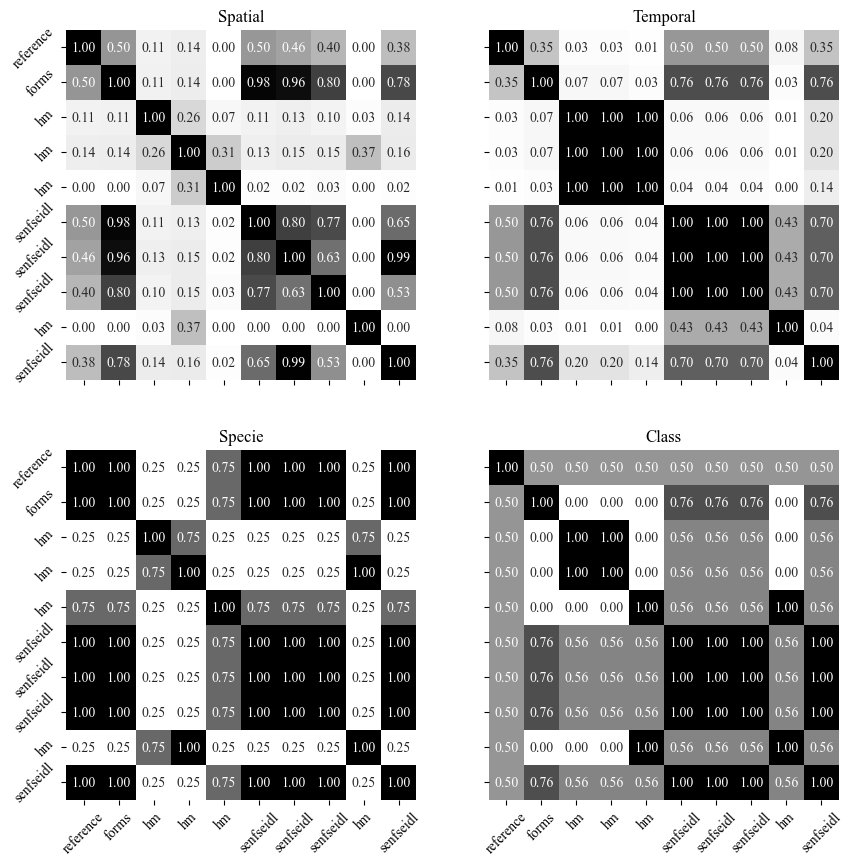

In [156]:
from utils import compute_similarity_matrix, compute_tree_coherence, compute_class_similarity

import seaborn as sns
import matplotlib.pyplot as plt
#change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
similarity_matrix, matrices = compute_similarity_matrix(data, attribution.dtypes_, {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': attribution.dclass_score}, 1.0)}, final_weighting_dict=attribution.final_weighting_dict)
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

dname = {
    'spatial': 'Spatial',
    'temporal': 'Temporal',
    'tree specie relatedness': 'Specie',
    'class relatedness': 'Class'
}

#set the colormap for each matrix, the figure is for an article so we use a colorblind friendly colormap, I want cmap that start form white
#use another cmap than Greys
dcmap = {
    'spatial': 'Greys',
    'temporal': 'Greys',
    'tree specie relatedness': 'Greys',
    'class relatedness': 'Greys'
}



axes_ = [ (0,0), (0,1), (1,0), (1,1) ]

for ax, (name, matrices) in zip(axes_, matrices.items()):
    axes[ax].set_title(dname[name])
    sns.heatmap(matrices, annot=True, cmap='Greys', square=True, ax=axes[ax], cbar=False, fmt='.2f')

#set xticks and yticks as the dataset name with 45° rotation
for ax in axes_:
    axes[ax].set_xticklabels(data.dataset, rotation=45)
    axes[ax].set_yticklabels(data.dataset, rotation=45)




In [157]:
fig.savefig('../figures/similarity_matrix.png', dpi=300, bbox_inches='tight')

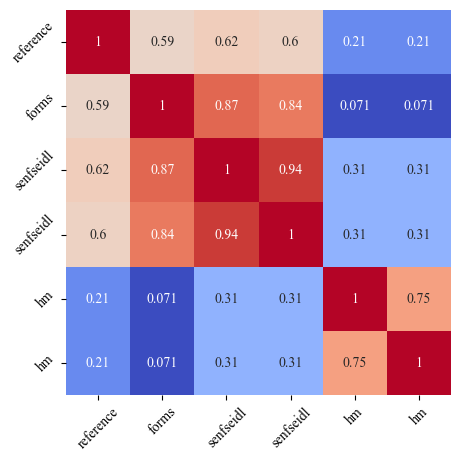

In [149]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', square=True, cbar=False, ax=ax)
_ = ax.set_xticklabels(data.dataset, rotation=45)
_ = ax.set_yticklabels(data.dataset, rotation=45)

In [158]:
from utils import get_cluster
cluster = get_cluster(data,  {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 
                    'class relatedness': (compute_class_similarity, {'dclass_score': attribution.dclass_score}, 1.0)},
                      attribution.dtypes_, 
                      attribution.final_weighting_dict , 
                      attribution.doa, 
                      attribution.dclass_score, 
                        threshold=0.)

cluster

,Similarity,Class,Indexes,Start_Date,End_Date,index_reference
0,0.596782,anthropogenic,"[405, 409, 410, 411, 413]",2017-09-25 14:24:00,2018-08-31 04:48:00,1008123
2,0.261697,biotic-mortality,"[408, 412]",2017-07-02 00:00:00,2018-07-01 12:00:00,1008123
1,0.227151,biotic-dieback,"[406, 407]",2016-01-01 00:00:00,2016-12-31 00:00:00,1008123


In [109]:
rows = []
for _, row in cluster.iterrows():
    indexes = row.Indexes
    for j in indexes:
        row_ = attribution_year.iloc[j]
        row_['cluster'] = row['Class'] 
        row_['start_date'] = row['Start_Date']
        row_['end_date'] = row['End_Date']
        rows.append(row_)

#build gdf from rows
gdf = gpd.GeoDataFrame(rows, geometry='geometry', crs='EPSG:2154')

col =  ['start_date', 'end_date', 'essence', 'cluster', 'notes', 'geometry']
viz = gdf[col]
viz['start_date'] = viz['start_date'].astype(str)
viz['end_date'] = viz['end_date'].astype(str)
viz.explore(column = 'cluster', 
             tooltip = ['start_date', 'end_date', 'essence', 'cluster', 'notes'], 
             tiles = 'Esri.WorldImagery',
             marker_kwds=dict(radius=5, fill=True))

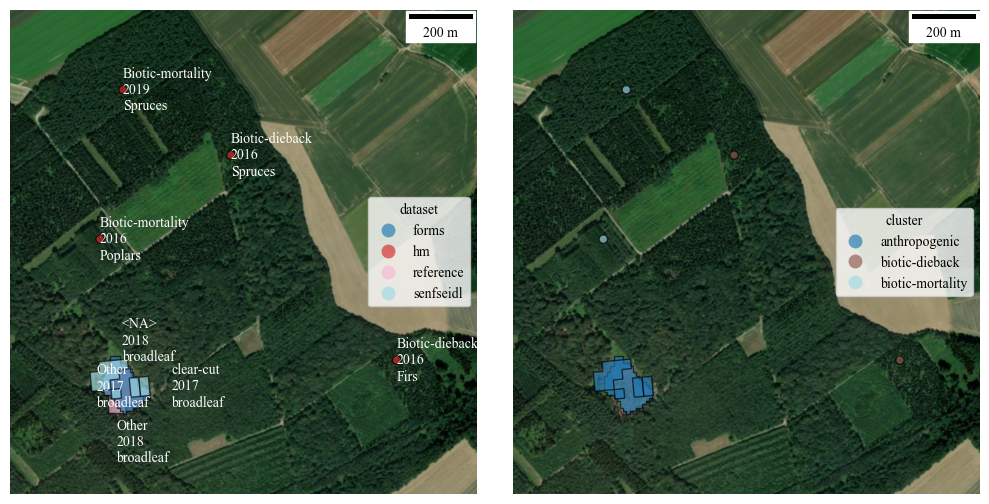

In [185]:
rows = []
for _, row in cluster.iterrows():
    indexes = row.Indexes
    for j in indexes:
        row_ = attribution_year.iloc[j]
        row_['cluster'] = row['Class'] 
        row_['start_date'] = row['Start_Date']
        row_['end_date'] = row['End_Date']
        rows.append(row_)

#build gdf from rows
gdf = gpd.GeoDataFrame(rows, geometry='geometry', crs='EPSG:2154')

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

l = [data, gdf]
for k, ax in enumerate(axes):

    xmin, ymin, xmax, ymax = dataset.buffer(250).total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    dataset = l[k]
    if k == 0:
        
        column = 'dataset'
    else:
        column = 'cluster'

    dataset.plot(ax=ax, column=column, cmap='tab20', edgecolor='black', alpha=0.65, legend=True, legend_kwds={'loc': 'center right', 'title': column})
    ctx.add_basemap(ax, crs=dataset.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution=False)
    ax.add_artist(ScaleBar(1))
    ax.axis('off')



    delta = 150
    directions = [
        (0, delta),             # North
        (delta/2, delta/2),     # Northeast
        (delta, 0),             # East
        (delta/2, -delta/2),    # Southeast
        (0, -delta),            # South
        (-delta/2, -delta/2),   # Southwest
        (-delta, 0),            # West
        (-delta/2, delta/2)     # Northwest
    ]

    j = 0
    txts = []
    if k == 0:
        for i, row in dataset.iterrows():
            if row.geometry.type == 'Point':
                x, y = row.geometry.centroid.x, row.geometry.centroid.y

                # Adjust position if necessary
                
                ax.annotate(f"{row['class']}\n{row['start_date'].year}\n{row['essence']}", xy=(x, y), horizontalalignment='left', verticalalignment='center', color='white', fontsize=10)

            else:
                #annotate in the lower left corner and avoid overlapping using i 
                txt = f"{row['class']}\n{row['start_date'].year}\n{row['essence']}"
                if txt not in txts:
                    txts.append(txt)
                    x, y = row.geometry.centroid.x, row.geometry.centroid.y
                    x, y = x + directions[j][0], y + directions[j][1]
                    ax.annotate(txt, xy=(x, y), horizontalalignment='left', verticalalignment='center', color='white', fontsize=10)
                    j += 2

plt.tight_layout()
plt.show()


In [186]:
fig.savefig(f'../figures/group_cluster_{year}_{index}.png', dpi=300, bbox_inches='tight')